In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("game_data_365days.csv")


We load the daily game data for 365 days, parsing dates, and performing initial sanity checks on types and ranges

In [34]:
display(df.head())
display(df.info())
display(df.describe(include='all'))

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

,date,new_users,dau,mau,r1,r7,r30,revenue,event_new_content,event_promotion,event_seasonal,event_community,event_limited_time,day_of_week,is_weekend,month,is_holiday
0,2024-01-01,1024,4919,15097,0.398,0.248,0.154,11988,1,0,0,0,0,0,0,1,1
1,2024-01-02,1001,5095,14548,0.412,0.238,0.143,11264,0,0,0,1,0,1,0,1,0
2,2024-01-03,1042,5073,15277,0.380,0.259,0.172,12051,1,0,0,0,0,2,0,1,0
3,2024-01-04,1081,5073,14254,0.448,0.255,0.161,15460,1,0,0,0,1,3,0,1,0
4,2024-01-05,985,4865,15650,0.444,0.264,0.165,10634,0,0,0,0,0,4,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                365 non-null    object 
 1   new_users           365 non-null    int64  
 2   dau                 365 non-null    int64  
 3   mau                 365 non-null    int64  
 4   r1                  365 non-null    float64
 5   r7                  365 non-null    float64
 6   r30                 365 non-null    float64
 7   revenue             365 non-null    int64  
 8   event_new_content   365 non-null    int64  
 9   event_promotion     365 non-null    int64  
 10  event_seasonal      365 non-null    int64  
 11  event_community     365 non-null    int64  
 12  event_limited_time  365 non-null    int64  
 13  day_of_week         365 non-null    int64  
 14  is_weekend          365 non-null    int64  
 15  month               365 non-null    int64  
 16  is_holid

None

,date,new_users,dau,mau,r1,r7,r30,revenue,event_new_content,event_promotion,event_seasonal,event_community,event_limited_time,day_of_week,is_weekend,month,is_holiday
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1072.802740,5356.150685,16155.775342,0.401904,0.250696,0.150071,11299.438356,0.068493,0.063014,0.019178,0.049315,0.032877,2.991781,0.284932,6.498630,0.010959
std,NaN,65.642384,290.317469,798.323875,0.040628,0.027153,0.017141,1441.502503,0.252937,0.243321,0.137339,0.216822,0.178559,2.006155,0.452001,3.448702,0.104252
min,NaN,894.000000,4612.000000,14254.000000,0.305000,0.183000,0.104000,9113.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,NaN,1026.000000,5150.000000,15528.000000,0.369000,0.231000,0.138000,10363.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000
50%,NaN,1074.000000,5362.000000,16251.000000,0.401000,0.250000,0.150000,10875.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,7.000000,0.000000
75%,NaN,1121.000000,5560.000000,16757.000000,0.432000,0.270000,0.163000,11594.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,9.000000,0.000000


The dataset contains no missing values across all fields --> simplifies preprocessing and ensures model inputs are complete

In [35]:
df.isna().sum()

df['date'].duplicated().sum()

for col in ['r1', 'r7', 'r30']:
    print(col, df[col].min(), df[col].max())

r1 0.305 0.493
r7 0.183 0.324
r30 0.104 0.193


Retention metrics (r1, r7, r30) evaluates for minimum and maximum values to ensure that all retention percentages were valid. Since retention rates should fall between 0 and 1, this step confirms there are no out-of-range values or data anomalies.

Data Issues, Gaps, and Constraints

1.Only 365 days of data -- The dataset covers just one year. Because of this we cannot compare year-over-year trends.Seasonal patterns (e.g., annual events, recurring spikes) are harder to learn. Models might think a one-time pattern will happen every year, leading to overfitting.
2. Daily data only -- All activity is measured per day. There is no hourly data or session-level data.
This means, we can’t study how players behave within a day. We can’t see short-term reactions to events (eg: a promotion that performs well only in the evening or weekend behaviors,new content could spike within few hours etc). Event effects are averaged across the whole day, which can hide important patterns.
3.Limited calendar detail -- Holidays are only marked as 1/0  there's no distinction between different types of holidays or lengths 4.Events are just 0/1 flags No info on event size, duration, or type,hard to explain why some events perform better than others

Recommendations
Collect more than one year of data - Better seasonal patterns and more stable forecasts

Add more detail to event data - Duration, category, or intensity would help explain impact

Improve calendar labels - Named holidays or longer holiday periods would capture external effects

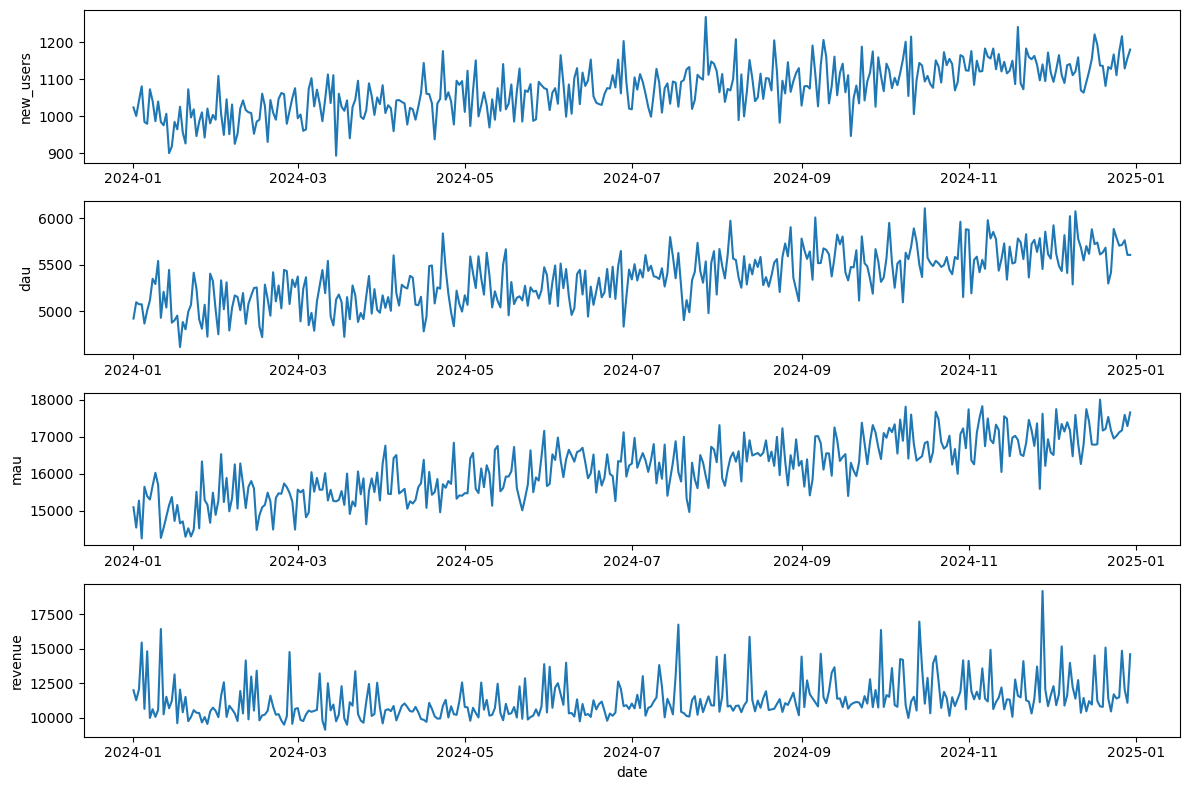

In [36]:
kpi_cols = ['new_users', 'dau', 'mau', 'revenue']

plt.figure(figsize=(12, 8))

for i, col in enumerate(kpi_cols, start=1):
    plt.subplot(len(kpi_cols), 1, i)
    plt.plot(df['date'], df[col])
    plt.ylabel(col)

plt.xlabel("date")
plt.tight_layout()
plt.show()


Plotted the key metrics over time to see how they move throughout the year
New Users stay fairly stable but show small ups and downs across the year

DAU slowly increases over time with normal daily fluctuations

MAU shows a slight upward trend with some noise which is expected for a monthly metric

Revenue has more sharp spikes compared to other metrics which may be linked to events or promotions

In [37]:
event_cols = [
    'event_new_content', 'event_promotion', 'event_seasonal',
    'event_community', 'event_limited_time'
]

event_effect = df.groupby(event_cols)['revenue'].mean().reset_index()
display(event_effect.head())


,event_new_content,event_promotion,event_seasonal,event_community,event_limited_time,revenue
0,0,0,0,0,0,10714.697595
1,0,0,0,0,1,14152.857143
2,0,0,0,1,0,12488.250000
3,0,0,0,1,1,15871.000000
4,0,0,1,0,0,13069.666667


grouped the data by event type to see how revenue changes when different events happen. The results show that days with events tend to have higher average revenue than days without events

In [38]:
numeric_cols = ['new_users', 'dau', 'mau', 'r1', 'r7', 'r30', 'revenue']
corr = df[numeric_cols].corr()
corr

,new_users,dau,mau,r1,r7,r30,revenue
new_users,1.000000,0.465255,0.577104,-0.004475,-0.040851,-0.009046,0.227016
dau,0.465255,1.000000,0.586780,0.077683,0.020958,0.025595,0.202659
mau,0.577104,0.586780,1.000000,0.062394,0.071575,0.072147,0.245724
r1,-0.004475,0.077683,0.062394,1.000000,0.708425,0.716462,0.099449
r7,-0.040851,0.020958,0.071575,0.708425,1.000000,0.698842,0.091241
r30,-0.009046,0.025595,0.072147,0.716462,0.698842,1.000000,0.056017
revenue,0.227016,0.202659,0.245724,0.099449,0.091241,0.056017,1.000000


Revenue is somewhat related to activity (DAU/MAU), but not extremely strongly, meaning other factors — like events — may be driving the spikes.

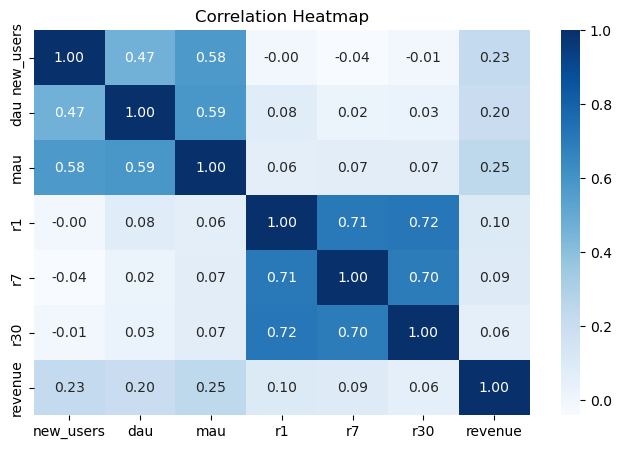

In [39]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


new_users, DAU, and MAU all have moderate positive correlations
This makes sense when more new users join, daily and monthly active users also increase.

r1, r7, and r30 are strongly correlated with each other. Players who return on Day 1 are more likely to return on later days as well

Revenue has weak-to-moderate correlation with activity numbers (new_users, DAU, MAU). This suggests revenue is influenced by activity but also by other factors like events.

Very low correlations (near 0) show metrics that don’t move together much such as new_users vs retention.

FEATURE ENGINEERING

In [40]:
def add_lags(df, col, lags):
    for lag in lags:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

df = df.copy()
df = add_lags(df, 'revenue', lags=[1, 2, 7])
df = add_lags(df, 'dau', lags=[1, 7])

df_model = df.dropna().reset_index(drop=True)


In [41]:
df_model

,date,new_users,dau,mau,r1,r7,r30,revenue,event_new_content,event_promotion,...,event_limited_time,day_of_week,is_weekend,month,is_holiday,revenue_lag1,revenue_lag2,revenue_lag7,dau_lag1,dau_lag7
0,2024-01-08,1041,5348,15682,0.491,0.286,0.179,10610,0,0,...,0,0,0,1,0,9971.0,14823.0,11988.0,5115.0,4919.0
1,2024-01-09,987,5291,16029,0.447,0.262,0.173,10051,0,0,...,0,1,0,1,0,10610.0,9971.0,11264.0,5348.0,5095.0
2,2024-01-10,1040,5540,15703,0.470,0.285,0.163,10559,0,0,...,0,2,0,1,0,10051.0,10610.0,12051.0,5291.0,5073.0
3,2024-01-11,985,4927,14269,0.423,0.294,0.171,16443,0,0,...,1,3,0,1,0,10559.0,10051.0,15460.0,5540.0,5073.0
4,2024-01-12,976,5208,14537,0.449,0.263,0.153,10238,0,0,...,0,4,0,1,0,16443.0,10559.0,10634.0,4927.0,4865.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2024-12-26,1174,5704,17124,0.365,0.248,0.165,11485,0,0,...,0,3,0,12,0,11389.0,11694.0,10818.0,5791.0,5610.0
354,2024-12-27,1216,5713,17178,0.425,0.257,0.140,14857,0,1,...,0,4,0,12,0,11485.0,11389.0,10778.0,5704.0,5632.0
355,2024-12-28,1129,5763,17596,0.428,0.259,0.155,12033,0,0,...,0,5,1,12,0,14857.0,11485.0,15093.0,5713.0,5683.0
356,2024-12-29,1157,5605,17292,0.455,0.258,0.157,11076,0,0,...,0,6,1,12,0,12033.0,14857.0,11400.0,5763.0,5297.0


created lag features (yesterday’s values, last week’s values) so the model can learn patterns over time. Time-series forecasting needs past data to predict future values, so these lag columns are essential

In [42]:
target_col = 'revenue'

drop_cols = ['date', 'revenue']
feature_cols = [c for c in df_model.columns if c not in drop_cols]

X = df_model[feature_cols]
y = df_model[target_col]

In [43]:
n = len(df_model)
train_size = int(n * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
dates_train = df_model['date'].iloc[:train_size]
dates_test  = df_model['date'].iloc[train_size:]

I used a Random Forest regressor as the main forecasting model. It was a practical choice for this test because it trains quickly, works well with mixed features, and can capture non-linear patterns in the data. The model uses lag features (past revenue and DAU), event indicators, and calendar information to learn trends and predict future revenue.

In [44]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RandomForest MAE:", mae)
print("RandomForest RMSE:", rmse)

RandomForest MAE: 558.4414185199912
RandomForest RMSE: 796.0769996270762


On average the models' predictions are about 558 units away from the actual revenue. The RMSE of around 796 shows that larger errors do occur but are not extreme. These results indicate that the model captures general trends reasonably well but still misses some of the sharp spikes in revenue, which are harder to predict.

Graphical predictions

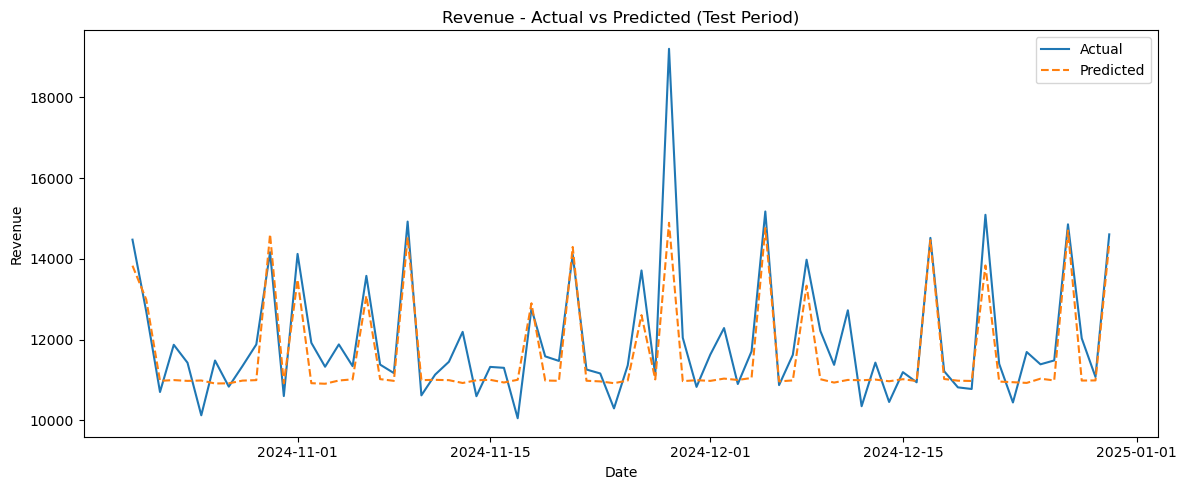

In [45]:
plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test.values, label="Actual")
plt.plot(dates_test, y_pred, label="Predicted", linestyle="--")
plt.title("Revenue - Actual vs Predicted (Test Period)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()


The Random Forest model tracks the overall revenue pattern well but misses some of the larger peaks. This is normal for a simple model with limited event detail.

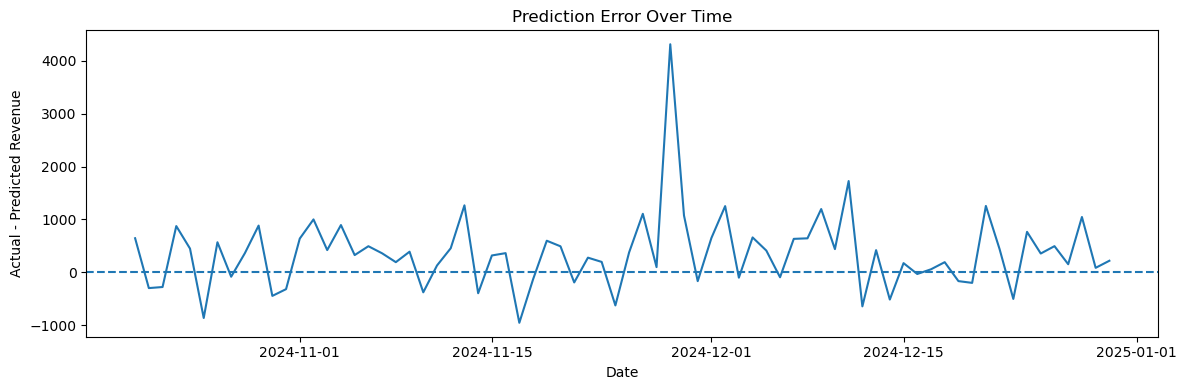

In [46]:
errors = y_test.values - y_pred

plt.figure(figsize=(12, 4))
plt.plot(dates_test, errors)
plt.axhline(0, linestyle="--")
plt.title("Prediction Error Over Time")
plt.xlabel("Date")
plt.ylabel("Actual - Predicted Revenue")
plt.tight_layout()
plt.show()


This plot shows the difference between actual and predicted revenue over time.
Most errors stay fairly close to zero, which means the model is generally accurate.
Larger spikes in the error happen on days when actual revenue jumps suddenly — these sharp increases are harder for the model to predict with the available features.

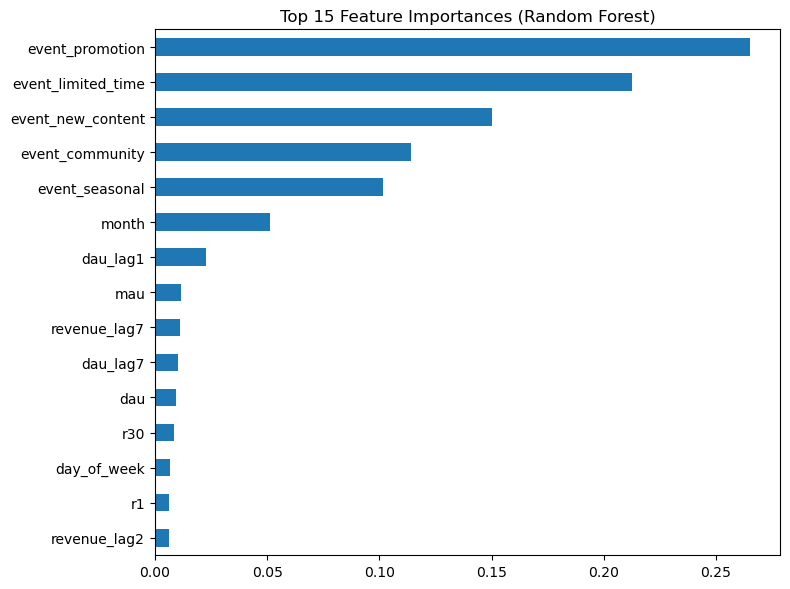

In [47]:
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


Events are the biggest contributors to revenue predictions while past activity and calendar features provide additional but smaller signals

In [48]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)

Linear Regression MAE: 438.00463923008095
Linear Regression RMSE: 562.4874610233147


The Linear Regression model worked surprisingly well and even performed better than the Random Forest. Its average error was about 438, with an RMSE of around 562. This means it followed the day-to-day revenue changes quite closely. It still missed some sharp spikes, but overall it captured the main trend effectively.

PLotting Random Forest vs Linear Regression

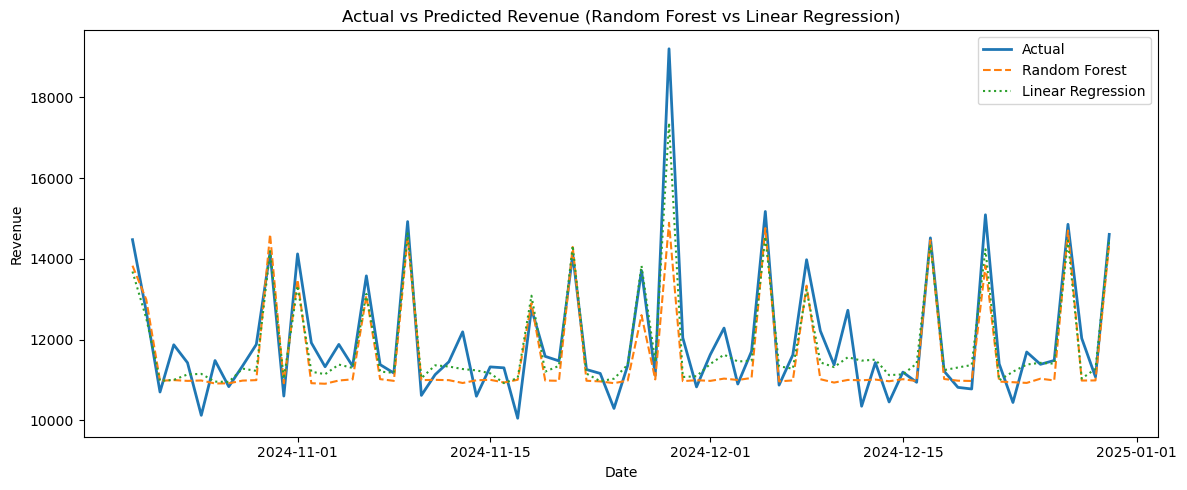

In [49]:
plt.figure(figsize=(12,5))

plt.plot(dates_test, y_test.values, label="Actual", linewidth=2)
plt.plot(dates_test, y_pred, label="Random Forest", linestyle="--")
plt.plot(dates_test, y_pred_lr, label="Linear Regression", linestyle=":")

plt.title("Actual vs Predicted Revenue (Random Forest vs Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()


Linear Regression follows the actual revenue more closely than Random Forest, especially on the smaller daily movements. Random Forest smooths out the spikes more, which leads to larger errors

Predictions Can Be Improved 

There are several ways the forecasting accuracy could be improved with more time and richer data
1. Use time-series models
Models like ARIMAX or more advanced approaches (eg. Seq2Seq) can better capture seasonality and long-term trends.
2. Add better features
Rolling averages (7-day, 14-day), volatility measures, and features like 'days since last event' would give the model more useful context.
3. Improve the data
Having more than one year of history and more detailed player data would allow the model to detect stronger patterns
Finer time granularity (eg, hourly data) would also help understand short-term reactions to events
4. Tune the models properly
Using time-series cross-validation and hyperparameter tuning would likely boost performance further

Time Spent

- Approximate total time: 1hour 45 minutes

Code Repository

- GitHub repository
